In [ ]:
! [ -e /content ] && pip install -Uqq fastai && rm -rf /usr/local/lib/python3.7/dist-packages/examples # colab

In [ ]:
#%cd ..
%cd fastai3-reactor

/content/fastai3-reactor


In [ ]:
import torch.nn as nn
from fastai.vision.all import *
from fastai.vision.gan import generate_noise
from src.GAN.gan_learner_a import *
from src.GAN.loss import *
from src.GAN.evolution_recorder import *
from examples.models.mnist_gan import *

In [ ]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [ ]:
def noise_fn(size):
    return lambda fn: generate_noise(fn, size=size)

In [ ]:
bs = 64
lr = 1e-4
epochs = 25
nz = 100
dropout_p = 0.0
loss = CrossEntropyLoss()

`GANLearner` in fastai2 does not support conditioanal GAN. This is a showcase of `AbstractGANLearner` flexibility that allows to pass conditions to both generator and discriminator without need to do any hacks.

# Unconditional version

In [ ]:
dblock = DataBlock((TransformBlock, ImageBlock(cls=PILImageBW)),
                   get_items=get_image_files,
                   getters=[noise_fn(nz), lambda path: path],
                   splitter=IndexSplitter([]),
                   batch_tfms=Normalize.from_stats([0.5], [0.5]))

dls = dblock.dataloaders(path, bs=bs)

In [ ]:
len(dls.train)

1093

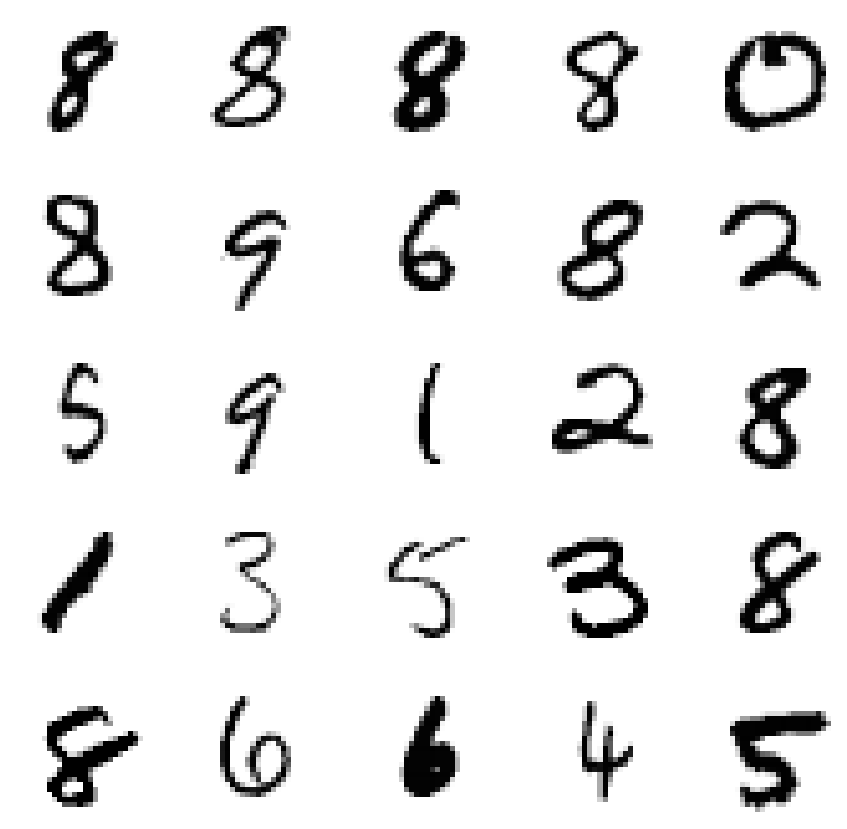

In [ ]:
dls.show_batch(max_n=25)

In [ ]:
gen = Generator(nz).cuda()
dis = Discriminator(dropout_p).cuda()

In [ ]:
rec1 = TempRecorderA(50)
rec2 = GANEvolutionRecorder(max_n=64, storege_path='examples/records/01/uncond')
cbs = [rec1, rec2]

In [ ]:
learn = GANLearnerA(dls, gen, dis, loss, cbs=cbs)
learn.fit(epochs, lr)

gen_loss=0.66930, dis_loss=0.83848
gen_loss=0.57328, dis_loss=0.77153
gen_loss=0.62615, dis_loss=0.96576
gen_loss=0.51571, dis_loss=1.13191
gen_loss=0.63168, dis_loss=0.95321
gen_loss=0.72391, dis_loss=0.93569
gen_loss=0.45781, dis_loss=1.50193
gen_loss=0.54945, dis_loss=0.99756
gen_loss=0.11915, dis_loss=2.07923
gen_loss=0.92366, dis_loss=1.28627
gen_loss=0.41316, dis_loss=1.91727
gen_loss=0.42547, dis_loss=1.53168
gen_loss=0.49366, dis_loss=1.36091
gen_loss=0.50259, dis_loss=1.28969
gen_loss=0.51932, dis_loss=1.21246
gen_loss=0.50176, dis_loss=1.31518
gen_loss=0.45012, dis_loss=1.26099
gen_loss=0.46193, dis_loss=1.09053
gen_loss=0.41633, dis_loss=1.69180
gen_loss=0.41798, dis_loss=1.32889
gen_loss=0.43842, dis_loss=1.33996
gen_loss=0.47746, dis_loss=1.34319
gen_loss=0.49561, dis_loss=1.22427
gen_loss=0.59768, dis_loss=1.03443
gen_loss=0.60628, dis_loss=1.20714
gen_loss=0.45695, dis_loss=1.31897
gen_loss=0.47038, dis_loss=1.34119
gen_loss=0.46187, dis_loss=1.36190
gen_loss=0.52006, di

In [ ]:
rec2.plot_animation()

# Conditional version

Now we can specify the number of input and target blocks by changing `n_inp` in `DataBlock` for predications tasks.

To configure `DataBlock` for GAN we need to have `n_gen` and `n_dis` parameters.

`n_gen` defines the number of input blocks (tensors) for generator with exception of the blocks with conditions which are shared by generator and discrimintator.

`n_dis` defines the number of input blocks for discrimintator with exception of the blocks with conditions. It is assumed that those blocks are what generator tries to generate.



Generator inputs are formed from batch `b` as `*b[:n_gen], *b[n_gen+n_dis:]`

Discriminator inputs are formed from the batch as `*b[n_gen:]` when it discriminates real samples and as `*gen_out, *b[n_gen+n_dis:]` when it discriminates fake samples `gen_out`. 

Blocks with the indices starting from `n_gen+n_dis` are considered as the conditions shared by generator and discriminator. Note that in current implementation you should avoid in place operations with conditions.

Possibly, in future `n_inp`, `n_gen`, `n_dis` should be something that is set on Learner level.

In [ ]:
# Here n_gen=n_dis=1, 
# TransformBlock is generator only input
# ImageBlock is discriminator only input and also is a block that generator tries to generate
# CategoryBlock used by generator and discriminator
dblock = DataBlock((TransformBlock, ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_image_files,
                   getters=[noise_fn(nz), lambda path: path, parent_label],
                   splitter=IndexSplitter([]),
                   batch_tfms=Normalize.from_stats([0.5], [0.5]))

dls = dblock.dataloaders(path, bs=bs)

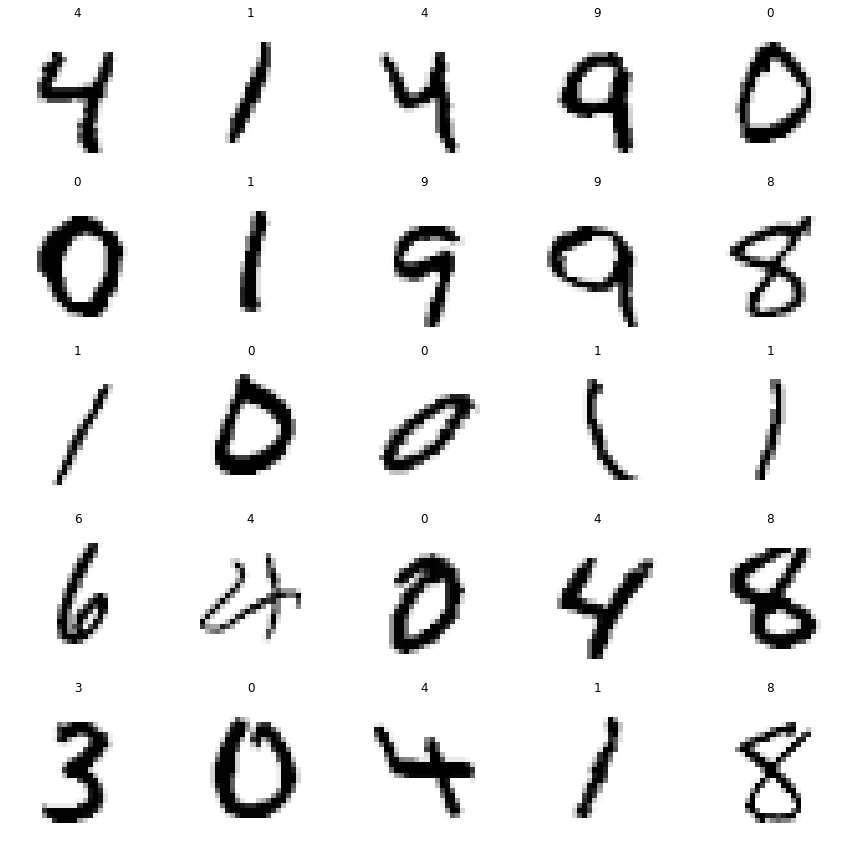

In [ ]:
# don't work well without typedispatch
# reqiers typedispatch which can look inside tuple for future ...
@typedispatch
def show_batch(xx:tuple, y:TensorCategory, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    x1 = xx[0]
    x2 = xx[1]
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](y, x2, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

dls.show_batch(max_n=25)

In [ ]:
gen = ConditionalGenerator(nz).cuda()
dis = ConditionalDiscriminator(dropout_p).cuda()

In [ ]:
rec1 = TempRecorderA(50)
rec2 = GANEvolutionRecorder(max_n=64, storege_path='examples/records/01/cond')
cbs = [rec1, rec2]

In [ ]:
learn = GANLearnerA(dls, gen, dis, loss, cbs=cbs)
learn.fit(epochs, lr)

gen_loss=0.64671, dis_loss=0.92247
gen_loss=0.61791, dis_loss=0.74490
gen_loss=0.48473, dis_loss=1.03987
gen_loss=0.46639, dis_loss=1.32120
gen_loss=0.45949, dis_loss=1.42209
gen_loss=0.46427, dis_loss=1.35441
gen_loss=0.55921, dis_loss=1.08043
gen_loss=0.45387, dis_loss=1.35815
gen_loss=0.50275, dis_loss=1.40837
gen_loss=0.74203, dis_loss=1.04141
gen_loss=0.67767, dis_loss=0.75296
gen_loss=0.29388, dis_loss=2.11988
gen_loss=0.21064, dis_loss=1.89570
gen_loss=0.62357, dis_loss=1.16091
gen_loss=0.50509, dis_loss=1.14463
gen_loss=0.47124, dis_loss=1.25465
gen_loss=0.31661, dis_loss=1.31343
gen_loss=0.44465, dis_loss=1.41823
gen_loss=0.49085, dis_loss=1.37162
gen_loss=0.41991, dis_loss=1.40381
gen_loss=0.50749, dis_loss=1.38283
gen_loss=0.42088, dis_loss=1.48160
gen_loss=0.46938, dis_loss=1.34050
gen_loss=0.47955, dis_loss=1.29615
gen_loss=0.53382, dis_loss=1.19609
gen_loss=0.47121, dis_loss=1.14216
gen_loss=0.47162, dis_loss=1.52746
gen_loss=0.44242, dis_loss=1.42590
gen_loss=0.44856, di

In [ ]:
# they usually match

In [ ]:
rec2.test_batch[1]

tensor([1, 0, 6, 9, 1, 4, 8, 9, 7, 7, 9, 7, 0, 7, 2, 9, 6, 8, 0, 1, 9, 8, 0, 1,
        1, 9, 1, 4, 8, 0, 7, 3, 5, 2, 6, 3, 5, 8, 1, 7, 7, 0, 2, 3, 2, 7, 2, 4,
        6, 7, 9, 8, 1, 4, 9, 4, 9, 1, 8, 8, 7, 4, 9, 3], device='cuda:0')

In [ ]:
rec2.plot_animation()